In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/automatic-ticket-classification-dataset/Automatic-Ticket-Classification-Dataset/complaints-2021-05-14_08_16.json


### Intro
For a financial company, customer complaints carry a lot of importance, as they are often an indicator of the shortcomings in their products and services. If these complaints are resolved efficiently in time, they can bring down customer dissatisfaction to a minimum and retain them with stronger loyalty. This also gives them an idea of how to continuously improve their services to attract more customers.

These customer complaints are unstructured text data; so, traditionally, companies need to allocate the task of evaluating and assigning each ticket to the relevant department to multiple support employees. This becomes tedious as the company grows and has a large customer base.

 #### In this case study, you will be working as an NLP engineer for a financial company that wants to automate its customer support tickets system. As a financial company, the firm has many products and services such as credit cards, banking and mortgages/loans.

## Business goal
 We need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

 We will be doing topic modelling on the .json data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 

 With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

##### Pipelines that needs to be performed:
You need to perform the following eight major tasks to complete the assignment:

1.Data loading

2.Text preprocessing

3.Exploratory data analysis (EDA)

4.Feature extraction

5.Topic modelling 

6.Model building using supervised learning

7.Model training and evaluation

8.Model inference

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()

#Importing libraries required for the case study and to plot charts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

In [3]:
#Importing Regular Expressions for String manipulation
import re

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [4]:
# root path for kaggle 
root_path = '/kaggle/input/automatic-ticket-classification-dataset/Automatic-Ticket-Classification-Dataset/complaints-2021-05-14_08_16.json'

In [5]:
# Opening JSON file 
f = open(root_path) 



In [6]:
# returns JSON object as a dictionary 
data = json.load(f)

In [7]:
df=pd.json_normalize(data)

In [8]:
df.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [10]:
df.isnull().sum()

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

In [11]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [12]:
# USe the required columns for the project
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product',]]
df.head()

,_source.complaint_what_happened,_source.product,_source.sub_product
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [13]:
# lets rename the column names to be more read friendly
# we have retained product and sub_product only for verification purpose ,
# these columns will not be used in the Topic modelling
df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})
df.head()

,complaint_text,category,sub_category
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [14]:
# lets merge the category and sub-category this will help us in deciding the topics after NMF modelling
df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'],axis= 1)
df.head()

,complaint_text,category
0,,Debt collection+Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...
3,,Mortgage+Conventional home mortgage
4,,Credit card or prepaid card+General-purpose cr...


In [15]:
# lets check the nan complaints
df.complaint_text.isnull().sum()

0

In [16]:
# lets check the empty string complaints
len(df[df['complaint_text']==''])

57241

In [17]:
#Assign nan in place of blanks in the complaints column
# lets replace empty complain with nan value
df[df['complaint_text']==''] = np.nan
df.complaint_text.isnull().sum()

57241

In [18]:
#Remove all rows where complaints column is nan
# Lets drop all the rows where complaint_text is null
df = df[~df['complaint_text'].isnull()]
df.complaint_text.isnull().sum()

0

In [19]:
# Preparing text for Topic modelling
def clean_text(text):
    text = text.lower()  # Make the text lowercase
    text = re.sub('\[.*\]','', text).strip() # Remove text in square brackets
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub('\S*\d\S*\s*','', text).strip()  # Remove words containing numbers
    return text.strip()

In [20]:
df.complaint_text = df.complaint_text.apply(lambda x: clean_text(x))
df.complaint_text.head()

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in and was told b...
10    chase card was reported on however fraudulent ...
11    on while trying to book a xxxx  xxxx  ticket i...
14    my grand son give me check for i deposit it in...
Name: complaint_text, dtype: object

In [21]:
#Write your function to Lemmatize the texts
# lemmatization
#Function to Lemmatize the texts
stopwords = nlp.Defaults.stop_words
def lemmatizer(text):
    doc = nlp(text)
    sent = [token.lemma_ for token in doc if not token.text in set(stopwords)]
    return ' '.join(sent)

In [22]:
# Lemmatize the complaints
df['lemma'] =  df.complaint_text.apply(lambda x: lemmatizer(x))
df.head()

,complaint_text,category,lemma
1,good morning my name is xxxx xxxx and i apprec...,Debt collection+Credit card debt,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told b...,Credit card or prepaid card+General-purpose cr...,upgrade xxxx xxxx card tell agent upgrade anni...
10,chase card was reported on however fraudulent ...,"Credit reporting, credit repair services, or o...",chase card report fraudulent application submi...
11,on while trying to book a xxxx xxxx ticket i...,"Credit reporting, credit repair services, or o...",try book xxxx xxxx ticket come offer apply...
14,my grand son give me check for i deposit it in...,Checking or savings account+Checking account,grand son check deposit chase account fund cle...


In [23]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint_text','lemma','category']]
df_clean.head()

,complaint_text,lemma,category
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o..."
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o..."
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account


In [24]:
#Write your function to extract the POS tags NN
def extract_pos_tags(text):
    doc = nlp(text)
    sent = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(sent)
    

In [25]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean['complaint_POS_removed'] =  df_clean.lemma.apply(lambda x: extract_pos_tags(x))
df_clean.head()

,complaint_text,lemma,category,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help bank service chase debt verificat...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date change age...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o...",book ticket come offer ticket reward card info...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,son deposit chase account fund bank account pa...


In [26]:
import plotly.express as px
import pandas as pd

# Assuming df_clean is your DataFrame and 'complaint_POS_removed' is the column of interest
doc_lens = [len(d) for d in df_clean['complaint_POS_removed']]

# Create a DataFrame to hold the lengths for easier plotting with Plotly
lengths_df = pd.DataFrame({'Document Length': doc_lens})

# Plotting using Plotly Express
fig = px.histogram(lengths_df, x='Document Length', nbins=50, title='Distribution of Complaint Character Lengths')

# Update layout for better appearance
fig.update_layout(
    xaxis_title='Character Length',
    yaxis_title='Count',
    bargap=0.1,
    width=1000,
    height=600
)

fig.show()


In [27]:
!pip install wordcloud

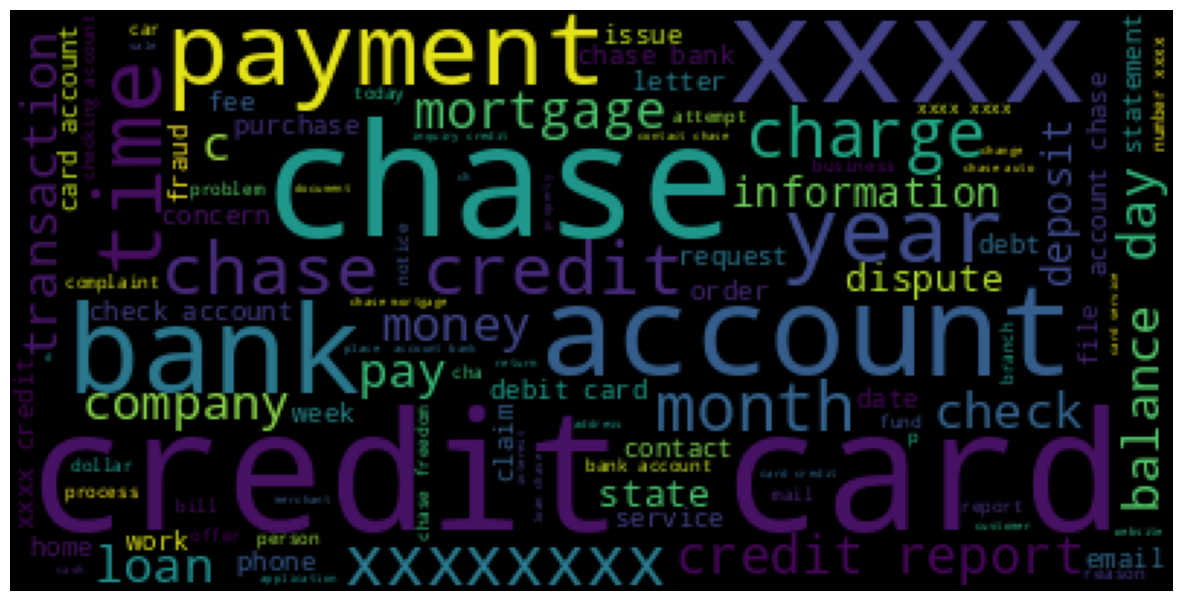

In [28]:
#Using a word cloud find the top 100 words by frequency among all the articles after processing the text

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=stopwords,max_words=100).generate(str(df_clean.complaint_POS_removed))

print(wordcloud)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [29]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean = df_clean.drop(['complaint_POS_removed'],axis = 1)

In [30]:
# Write your code here to find the top 30 unigram,bigram,trigram frequency 
# among the complaints in the cleaned datafram(df_clean).

def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

In [31]:
top_30_unigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=1, top=30)
top_30_bigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=2, top=30)
top_30_trigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=3, top=30)

In [32]:
#Print the top 10 words in the unigram frequency
print('Top 10 unigrams:\n')
top_30_unigrams[:10]

Top 10 unigrams:



[('chase', 53419),
 ('account', 40961),
 ('credit', 33554),
 ('xxxx', 31291),
 ('card', 29835),
 ('payment', 21064),
 ('bank', 17038),
 ('time', 15871),
 ('charge', 15292),
 ('day', 12831)]

In [33]:
# Convert the list to a DataFrame
unigram_df = pd.DataFrame(top_30_unigrams, columns=['Unigram', 'Count'])

# Plotting using Plotly Express
fig_unigrams = px.bar(unigram_df, x='Unigram', y='Count', title='Top 30 Unigrams')
fig_unigrams.update_layout(
    xaxis_title='Unigram',
    yaxis_title='Count',
    width=800,
    height=400
)

fig_unigrams.show()



In [34]:
# Convert the list to a DataFrame
bigram_df = pd.DataFrame(top_30_bigrams, columns=['Bigram', 'Count'])

# Plotting using Plotly Express
fig_bigrams = px.bar(bigram_df, x='Bigram', y='Count', title='Top 30 Bigrams')
fig_bigrams.update_layout(
    xaxis_title='Bigram',
    yaxis_title='Count',
    width=800,
    height=400
)

fig_bigrams.show()

In [35]:
# Convert the list to a DataFrame
trigram_df = pd.DataFrame(top_30_trigrams, columns=['Trigram', 'Count'])

# Plotting using Plotly Express
fig_trigrams = px.histogram(trigram_df, x='Trigram', y='Count', title='Top 30 Trigrams')
fig_trigrams.update_layout(
    xaxis_title='Trigram',
    yaxis_title='Count',
    width=800,
    height=400
)

fig_trigrams.show()

The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis


In [36]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [37]:
#All masked texts has been removed
df_clean.head()

,complaint_text,lemma,category,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help bank service chase debt verificat...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date change age...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o...",book ticket come offer ticket reward card info...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,son deposit chase account fund bank account pa...


 #### Convert the raw texts to a matrix of TF-IDF features¶
max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words" max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

min_df is used for removing terms that appear too infrequently min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [38]:
 #code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

In [39]:
# code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.Complaint_clean) 

In [40]:
tfidf.get_feature_names_out()[:10]

array(['aarp', 'abandonment', 'abatement', 'abbreviation', 'abd',
       'abhorrent', 'abide', 'ability', 'abovementione', 'abovereference'],
      dtype=object)

In [41]:
len(tfidf.get_feature_names_out())

6484

 # Topic Modelling using NMF¶
### Non-Negative Matrix Factorization (NMF) It is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task we are performing the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [42]:
from sklearn.decomposition import NMF

In [43]:
#Load your nmf_model with the n_components i.e 5
num_topics =  5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

W1 = nmf_model.fit_transform(dtm)
H1 = nmf_model.components_

In [44]:
#Print the Top25 words for each of the topics
num_words=25

vocab = np.array(tfidf.get_feature_names_out())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [45]:
vocab

array(['aarp', 'abandonment', 'abatement', ..., 'zombie', 'zone', 'zoom'],
      dtype=object)

In [46]:
len(vocab)

6484

In [47]:
topics

['account check money bank deposit chase fund day branch transfer number business transaction customer claim time cash phone information fraud reason access debit person issue',
 'card credit chase balance account score limit year purchase point month application service reason time offer customer freedom pay use company issue reward number letter',
 'payment loan mortgage chase month modification time home pay year rate balance property statement date foreclosure day letter request process auto document refinance state sale',
 'report inquiry credit information company reporting debt account file identity remove dispute theft score letter agency date creditor proof request authorization consumer contact application collection',
 'charge dispute fee chase transaction merchant claim purchase refund fraud service email time contact statement overdraft company day file item letter state date case pay']

In [48]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(df_clean.Complaint_clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.03,0.00,0.02,0.02,0.01,0
Doc1,0.01,0.02,0.00,0.00,0.01,1
Doc2,0.00,0.03,0.00,0.04,0.00,3
Doc3,0.02,0.03,0.01,0.05,0.01,3
Doc4,0.07,0.00,0.01,0.00,0.00,0


In [49]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = significant_topic

In [50]:
pd.set_option('display.max_colwidth', 1)

In [51]:
df_clean[['complaint_text','Complaint_clean','category','Topic']][df_clean.Topic==1].head(3)

,complaint_text,Complaint_clean,category,Topic
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,card agent upgrade anniversary date change agent information order account anniversary date agent,Credit card or prepaid card+General-purpose credit card or charge card,1
23,i have a chase credit card which is incorrectly reporting data on my credit report the company is not helping resolve the issue,chase credit card datum credit report company issue,Credit card or prepaid card+General-purpose credit card or charge card,1
32,my chase amazon card was declined for a catering order i had placed for my brothers funeral in the amount of i contacted chase around noon today and was asked the last numbers of my chase savings account and the other user on my account i responded that i did not have a savings and i am only authorized user customer rep told me they would call me back in minutes to keep the line open i didnt receive a call back after an hour so i contacted chase from the first call i thought someone was using my card fraudulently i spoke to the rep who transferred me to a supervisor xxxx who said the card was activated and the transaction would process called the catering company and card was declined i then used my xxxx xxxx card to pay for the order xxxx xxxx texted me asking if i was authorizing purchase and i responded yes contacted caterer and xxxx xxxx was declined i contacted chase again spoke to rep was told the initial questions are used to trick people to see what there answer would be she told me the cvv code was incorrectly being input by the caterer and i responded that i had gone over the numbers and cvv used was correct she told me the card was cleared for the purchase and she would monitor it for hours called caterer card declined use a mastercard which processed went to use chase amazon at restaurant at xxxx pm tonight in the amount of it was declined i was told by chase i was not over limit still frustrated figuring out multiple declines after several conversations with chase stating the card would be ok to use embarrassed as the caterer kept suggesting i was over my limit which i pay my card in full every month and chase confirmed that i was under my limit with the transaction never been declined by either chase or xxxx xxxx before today after multiple assurances that i was all set and card would be monitored to make sure transaction would clear it never did,catering order place brother contact chase noon today number chase saving account user account respond user customer minute line hour contact chase card supervisor card transaction process catering company card card pay order purchase respond contact caterer contact question trick respond number cvv card purchase monitor hour call caterer card decline use mastercard process chase tonight decline chase limit figure decline conversation chase state card use caterer limit pay card month chase confirm limit transaction decline today assurance card monitor transaction,Credit card or prepaid card+General-purpose credit card or charge card,1


In [52]:
# Print the first 3 Complaint for each of the Topics
temp =df_clean[['complaint_text','Complaint_clean','category','Topic']].groupby('Topic').head(3)
temp.sort_values('Topic')

,complaint_text,Complaint_clean,category,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,Debt collection+Credit card debt,0
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,son deposit chase account fund bank account pay money speek son money bank money son call chase time check owner country time date check number claim number chase,Checking or savings account+Checking account,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document i am not being a shored or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself although i know that chase reserves the right to close my account at any time i do believe that their protocol has been in the past to give notice in the form of a written document this situation is truly affecting my livelihood and they dont seem to want to deal with me professionally thank you,account debit card branch customer service representative account branch remove fund deposit place employment return bank customer service representative fund post business day branch retrieve fund look account fund reverse statement business day state withdraw bank teller chase mail check business day recover fund owe account bind fee rent car payment write notice thing peace mind fact chase situatio

 #### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [53]:
#Create the dictionary of Topic names and Topics
topic_mapping = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_mapping)

In [54]:
df_clean.head()

,complaint_text,lemma,category,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning xxxx xxxx appreciate help stop chase bank cardmember service \n write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail month attempt collect debt \n right know information consumer \n\n chase account xxxx xxxx xxxx xxxx thank advance help,Debt collection+Credit card debt,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,Bank Account services
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,upgrade xxxx xxxx card tell agent upgrade anniversary date change turn agent give wrong information order upgrade account xxxx change anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent mislead,Credit card or prepaid card+General-purpose credit card or charge card,card agent upgrade anniversary date change agent information order account anniversary date agent,Credit card or prepaid card
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card report fraudulent application submit identity consent fraudulently obtain service extend credit verify identity applicant,"Credit reporting, credit repair services, or other personal consumer reports+Other personal consumer report",chase card report application submit identity consent service extend credit verify identity applicant,Theft/Dispute Reporting
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,try book xxxx xxxx ticket come offer apply ticket apply reward card information offer minute notify screen decision immediately contact xxxx refer chase bank immediately contact chase bank get notification screen tell 

In [65]:
import plotly.express as px

# Assuming df_clean is your DataFrame and 'Topic' is the column of interest
fig = px.bar(df_clean['Topic'].value_counts().reset_index(), 
             x='Topic', 
             y='count', 
             title='Class Imbalance in Topics',
             labels={'x': 'Topic', 'y': 'Count'})

# Update layout for better appearance
fig.update_layout(
    xaxis_title='Topic',
    yaxis_title='Count',
    width=1200,
    height=600
)

# Show the plot
fig.show()


## Model building using supervised learning, Model training & evaluation¶

 ##### Supervised model to predict any new complaints to the relevant Topics.
We now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [70]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data

training_data = df_clean[['Complaint_clean','Topic']]

In [71]:
training_data.head()

,Complaint_clean,Topic
1,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,Bank Account services
2,card agent upgrade anniversary date change agent information order account anniversary date agent,Credit card or prepaid card
10,chase card report application submit identity consent service extend credit verify identity applicant,Theft/Dispute Reporting
11,book ticket come offer ticket reward card information minute notify screen decision chase bank notification screen representative speak application state information credit offer account statement purchase ticket account ask application representative oblige application request proceed application chase fact credit account report credit report chase information credit report process application consent error,Theft/Dispute Reporting
14,son deposit chase account fund bank account pay money speek son money bank money son call chase time check owner country time date check number claim number chase,Bank Account services


In [72]:
## Reverse topic names mapping for supervised learning

reverse_topic_mapping = {
    'Bank Account services' :0,
    'Credit card or prepaid card':1,
    'Others':2,
    'Theft/Dispute Reporting':3,
    'Mortgage/Loan':4
}
#Replace Topics with Topic Names
training_data['Topic'] = training_data['Topic'].map(reverse_topic_mapping)
training_data.head()

,Complaint_clean,Topic
1,morning help bank service chase debt verification statement bank validate debt mail month attempt debt information consumer chase account help,0
2,card agent upgrade anniversary date change agent information order account anniversary date agent,1
10,chase card report application submit identity consent service extend credit verify identity applicant,3
11,book ticket come offer ticket reward card information minute notify screen decision chase bank notification screen representative speak application state information credit offer account statement purchase ticket account ask application representative oblige application request proceed application chase fact credit account report credit report chase information credit report process application consent error,3
14,son deposit chase account fund bank account pay money speek son money bank money son call chase time check owner country time date check number claim number chase,0


In [73]:
training_data[['Complaint_clean','Topic']][training_data.Topic==2].head(30)

,Complaint_clean,Topic
20,summer month experience income employment request month payment extension auto loan company chase year request payment extension grant auto loan payment request month payment extension deny year situation representative supervisor discussion wait inform reason decline reason denial baffle email director communication contact state chase followup week share role conference department hand request review information request base policy change state letter mail explanation letter reason denial policy change cfpb help payment extension request reason denial,2
57,loan modification chase payment,2
58,payment payment closing date statement statement purchase balance month statement purchase prior statement show purchase balance balance balance difference payment payment require chase purchase balance payment payment minimum interest rate balance time chase skirt law profit need help problem logic fall ear chase advance assistance,2
73,wire chase branch reinstatement order foreclosure property chase executive honor rule regulation payoff order foreclosure proceeding sale date resident time reinstatement foreclosure resort chapter bankruptcy filing assistant bring foreclosure trustee quality sense family default claim complaint complaint product mortgage issue foreclosure email,2
81,loan release title contact chase time resolution time release state registration state title rent car use car,2
82,report day payment pay call info balance finish day payment day day return payment man phone state payment credit account account charge fee return payment idea report credit day guy charge fee credit score drop point call,2
86,student loan chase bank sell account account attempt contact respond tell work department contact credit report payment credit call mail letter response,2
99,payment day current time loan modification loss mitigation assistance help chase loan forbearance option refinance debt decline time credit score low,2
127,member auto finance pay gap insurancewaiver coverage purchase time sign financing agreement station finance vehicle chase auto finance purchase vehicle financing agreement option purchase gap insurance provider gap insurance sign gap state purchase insurance agreement chase auto finance waive deficiency event vehicle chase auto finance write ship vehicle order reassign letter vehicle station vehicle accident chase honor gap insurancewaiver provision loss lien vehicle salvage value recover bank bank honor commitment cover deficiency insurance payout balance loan salvage value,2
141,action company date group contact chase claim claim payment creditor credit reverse fund fee transaction claim group individual payment loan pave claim group individual payment credit card date payment occur claim group individual payment payment reverse claim group individual payment payment payment payment date claim group individual hoa payment payment reverse claim group individual payment claim group individual payment claim group individual payment claim group individual payment payment reverse payment branch customer service representative advice account email debit card transaction total action resolve issue claim paperwork chase claim department claim speak rude transaction account information information hang call speak guy situation transaction transaction look claim claim hour claim specialist rude call claim specialist speak supervisor minute attempt attempt help money answer review claim practice protocol transfer chase office escalate claim office behalf claim office employee person contact number file case office week phone handful claim account claim claim account claim payment deduct chase account description number money debit account course leave message request return return call money debit account time explanation debit fund bit tell claim money debit return school dismiss day point investigation claim decision research investigation subpoena information point situation,2


##### Apply the supervised models on the training data created. In this process, you have to do the following:¶
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics

In [74]:
# x - y  split
X = training_data.Complaint_clean
y = training_data.Topic

In [75]:
# Fit transform the X
count_vect = CountVectorizer()
X_vect = count_vect.fit_transform(X)


In [77]:
#Fit transform word vector to TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_vect)

In [78]:
from sklearn.model_selection import train_test_split
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=40, stratify=y)

###### We are trying the following models ¶
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

Using the required evaluation metrics judge the tried models and select the ones performing the best

In [79]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [81]:
# utlity function to display the model report

def display_classification_report(model,metric):
    
    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    roc_auc_score_train = round(roc_auc_score(y_train, y_train_pred_proba,average='weighted',multi_class='ovr'),2)
    roc_auc_score_test = round(roc_auc_score(y_test, y_test_pred_proba,average='weighted',multi_class='ovr'),2)
    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)
    metric.append(roc_auc_score_train)
    metric.append(roc_auc_score_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    precision_train,recall_train,fscore_train,support_train=precision_recall_fscore_support(y_train,y_train_pred,average='weighted')
    precision_test,recall_test,fscore_test,support_test=precision_recall_fscore_support(y_test,y_test_pred,average='weighted')
    
    acc_score_train = round(accuracy_score(y_train,y_train_pred),2)
    acc_score_test = round(accuracy_score(y_test,y_test_pred),2)
    
    metric.append(acc_score_train)
    metric.append(acc_score_test)
    metric.append(round(precision_train,2))
    metric.append(round(precision_test,2))
    metric.append(round(recall_train,2))
    metric.append(round(recall_test,2))
    metric.append(round(fscore_train,2))
    metric.append(round(fscore_test,2))
    
    print('Train Accuracy :',acc_score_train)
    print('Test Accuracy :',acc_score_test)
        
    model_report_train = classification_report(y_train,y_train_pred)
    model_report_test = classification_report(y_test,y_test_pred)
    
    print('Classification Report for Train:\n',model_report_train)
    print('Classification Report for Test:\n',model_report_test)
    
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.xticks(rotation=80)

    plt.show();

In [82]:
# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)

In [83]:
# utility method to get the GridSearchCV object
def grid_search(model,folds,params,scoring):
    
    grid_search = GridSearchCV(model,
                                cv=folds, 
                                param_grid=params, 
                                scoring=scoring, 
                                n_jobs=-1, verbose=1)
    return grid_search

In [84]:
# utility function to display the best score and parameters of the GridSearchCV model
def print_best_score_params(model):
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

ROC AUC Score Train: 0.97
ROC AUC Score Test: 0.95
Train Accuracy : 0.79
Test Accuracy : 0.74
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.72      0.94      0.82      4332
           1       0.80      0.70      0.75      3110
           2       0.79      0.91      0.85      3802
           3       0.97      0.45      0.61      1632
           4       0.87      0.69      0.77      2928

    accuracy                           0.79     15804
   macro avg       0.83      0.74      0.76     15804
weighted avg       0.81      0.79      0.78     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.67      0.92      0.78      1444
           1       0.75      0.63      0.68      1037
           2       0.75      0.88      0.81      1267
           3       0.98      0.38      0.54       544
           4       0.83      0.63      0.72       976

    accuracy            

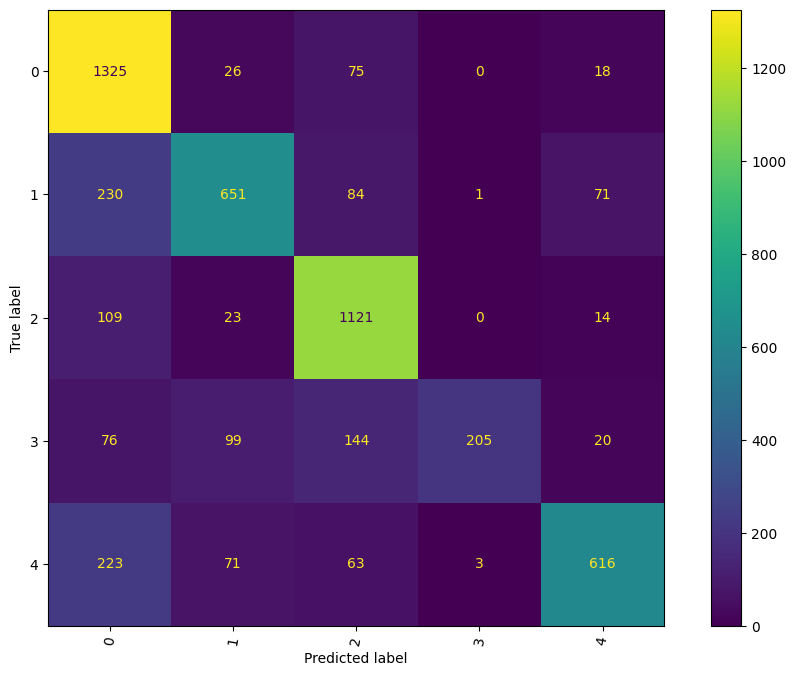

In [85]:
# Multinomial Naive Bayes Classification

# create MNB model object
mnb = MultinomialNB()
# fit model
mnb.fit(X_train, y_train)
# display classification report
metric1=[]
display_classification_report(mnb,metric1)

ROC AUC Score Train: 1.0
ROC AUC Score Test: 1.0
Train Accuracy : 0.97
Test Accuracy : 0.95
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      4332
           1       0.98      0.97      0.98      3110
           2       0.97      0.99      0.98      3802
           3       0.98      0.94      0.96      1632
           4       0.98      0.96      0.97      2928

    accuracy                           0.97     15804
   macro avg       0.98      0.97      0.97     15804
weighted avg       0.97      0.97      0.97     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1444
           1       0.95      0.94      0.94      1037
           2       0.95      0.97      0.96      1267
           3       0.98      0.91      0.94       544
           4       0.96      0.93      0.94       976

    accuracy              

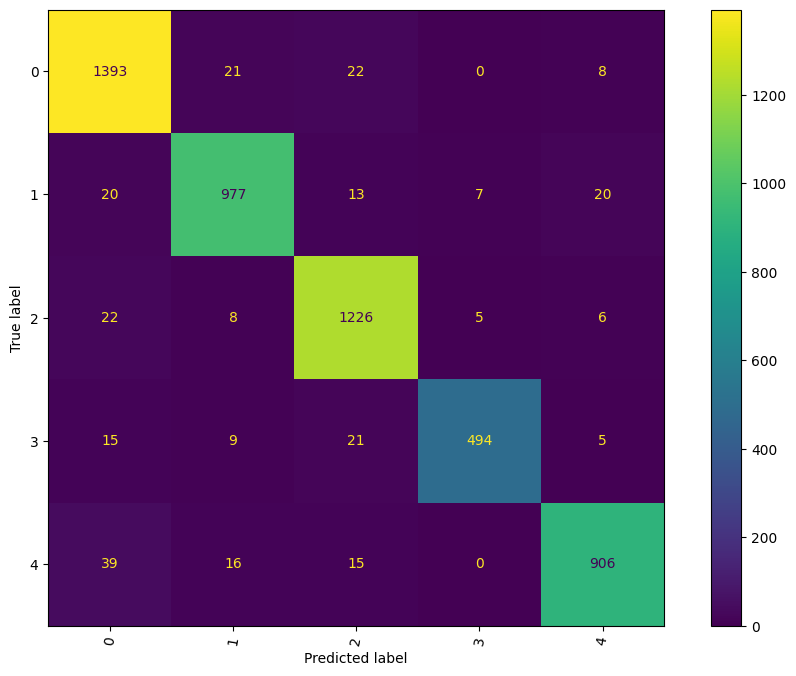

In [86]:
# Logistic Regression Classification
log_reg = LogisticRegression(random_state=40,solver='liblinear')
# fit model
log_reg.fit(X_train,y_train)
# display classification report
metric2=[]
display_classification_report(log_reg,metric2)

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.89
Train Accuracy : 1.0
Test Accuracy : 0.83
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4332
           1       1.00      1.00      1.00      3110
           2       1.00      1.00      1.00      3802
           3       1.00      1.00      1.00      1632
           4       1.00      1.00      1.00      2928

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.84      0.83      0.84      1444
           1       0.84      0.82      0.83      1037
           2       0.87      0.87      0.87      1267
           3       0.82      0.83      0.82       544
           4       0.77      0.81      0.79       976

    accuracy              

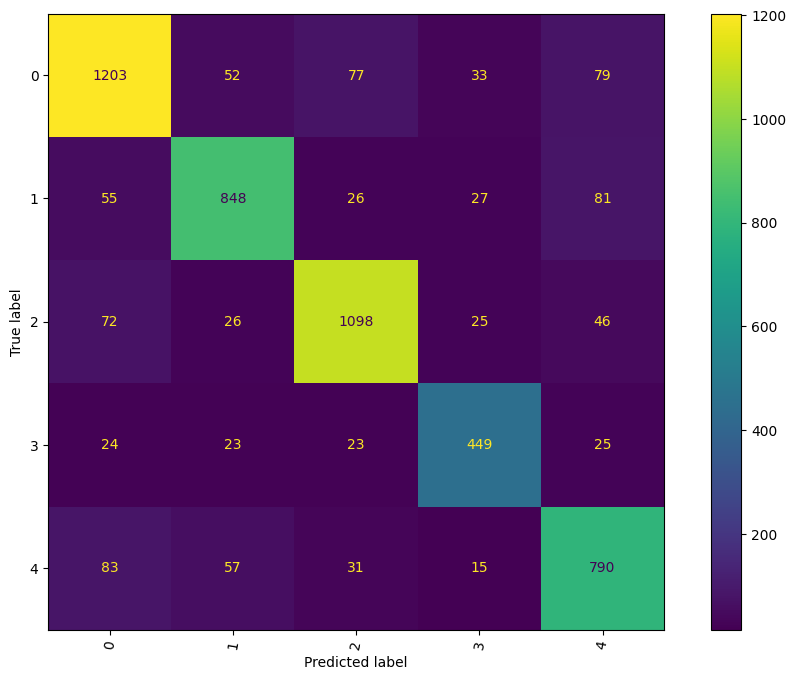

In [87]:
# Decision Tree Classification
dtc = DecisionTreeClassifier(random_state=40)
# fit model
dtc.fit(X_train,y_train)
# Decision Tree Classification Report
metric3=[]
display_classification_report(dtc,metric3)

OOB SCORE : 0.8718046064287522
ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.99
Train Accuracy : 1.0
Test Accuracy : 0.88
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4332
           1       1.00      1.00      1.00      3110
           2       1.00      1.00      1.00      3802
           3       1.00      1.00      1.00      1632
           4       1.00      1.00      1.00      2928

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89      1444
           1       0.87      0.85      0.86      1037
           2       0.90      0.92      0.91      1267
           3       0.92      0.81      0.86       544
           4       0.89      0.80      0.85       

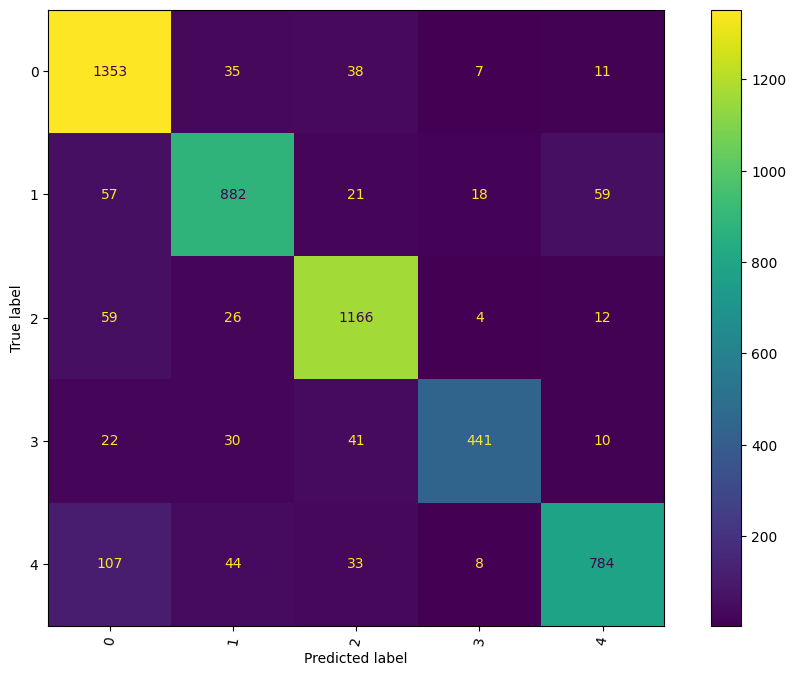

In [88]:
# Random Forest Classification

rf = RandomForestClassifier(n_estimators = 500,random_state=40, n_jobs = -1,oob_score=True)
# fit model
rf.fit(X_train,y_train)

# oob score
print('OOB SCORE :',rf.oob_score_)

# Random Forest Classification Report
metric4=[]
display_classification_report(rf,metric4)

# Hyper parameter Tuning

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score:  0.78340877145912
Best Hyperparameters:  {'alpha': 0.1}
ROC AUC Score Train: 0.98
ROC AUC Score Test: 0.95
Train Accuracy : 0.86
Test Accuracy : 0.78
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88      4332
           1       0.84      0.82      0.83      3110
           2       0.87      0.91      0.89      3802
           3       0.89      0.78      0.83      1632
           4       0.87      0.81      0.84      2928

    accuracy                           0.86     15804
   macro avg       0.86      0.85      0.85     15804
weighted avg       0.86      0.86      0.86     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81      1444
           1       0.73      0.68      0.70      1037
           2       0.81      0.86      0.84      1267
     

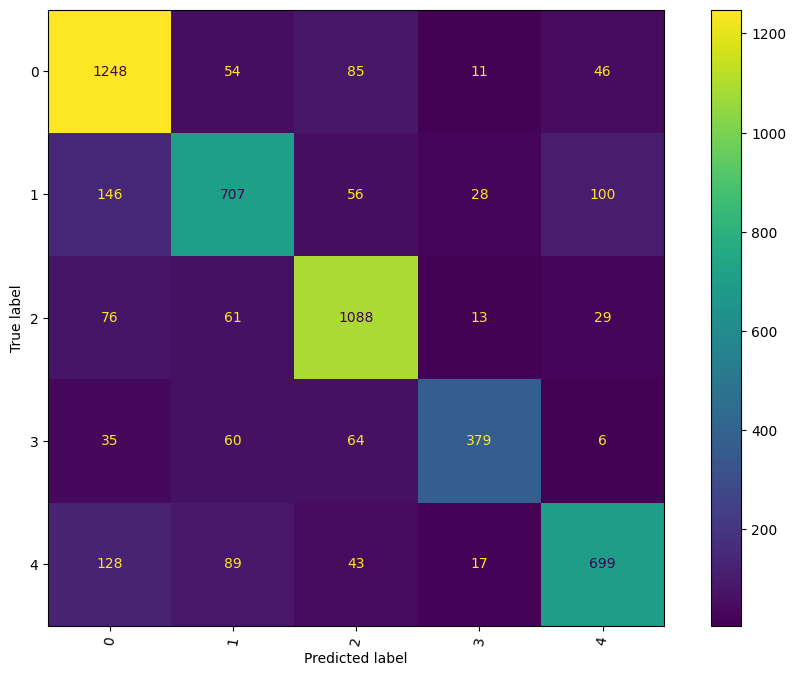

In [89]:
# Multinomial Naive Bayes with GridSearchCV

mnb = MultinomialNB()

mnb_params = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001)  
}

# create gridsearch object
grid_search_mnb = grid_search(mnb, folds, mnb_params, scoring=None)

# fit model
grid_search_mnb.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_mnb)

# Random Forest Classification Report
metric5=[]
display_classification_report(grid_search_mnb,metric5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best Score:  0.9589976733848845
Best Hyperparameters:  {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
ROC AUC Score Train: 1.0
ROC AUC Score Test: 1.0
Train Accuracy : 0.97
Test Accuracy : 0.96
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      4332
           1       0.98      0.97      0.97      3110
           2       0.97      0.98      0.97      3802
           3       0.97      0.96      0.96      1632
           4       0.97      0.97      0.97      2928

    accuracy                           0.97     15804
   macro avg       0.97      0.97      0.97     15804
weighted avg       0.97      0.97      0.97     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      1444
           1       0.96      0.96      0.96      1037
           2       0.97      0.98      0.97      1267
           3       0.96      0.95   

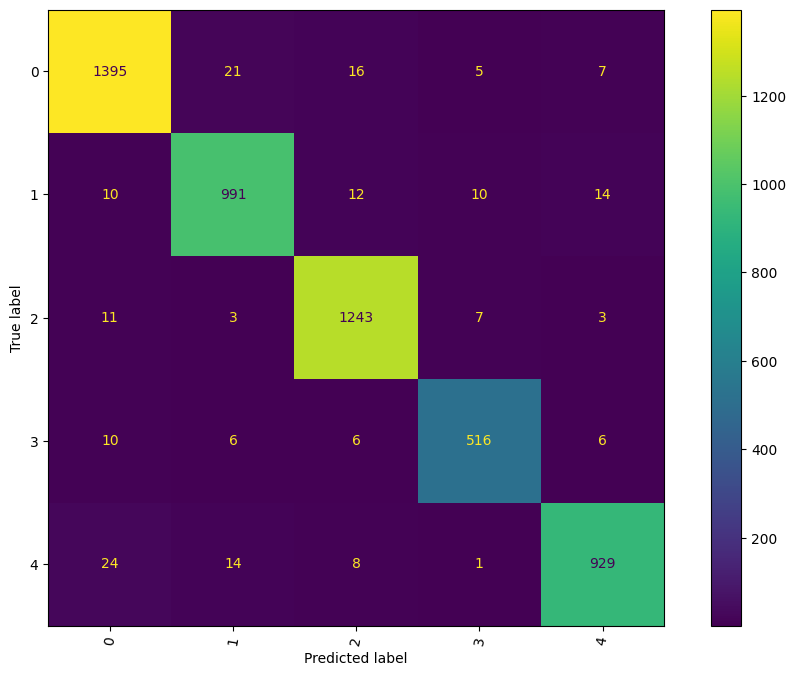

In [90]:
# Logistic Regression with GridSearchCV

# logistic regression
log_reg = LogisticRegression()

# hyperparameter for Logistic Regression
log_params = {'C': [0.01, 1, 10], 
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear','newton-cg','saga']
         }

# create gridsearch object
grid_search_log = grid_search(log_reg, folds, log_params, scoring=None)

# fit model
grid_search_log.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_log)

# Random Forest Classification Report
metric6=[]
display_classification_report(grid_search_log,metric6)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Score:  0.9586392213734627
Best Hyperparameters:  {'max_depth': 30, 'min_samples_leaf': 30}
ROC AUC Score Train: 0.98
ROC AUC Score Test: 0.96
Train Accuracy : 0.85
Test Accuracy : 0.83
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      4332
           1       0.86      0.86      0.86      3110
           2       0.89      0.88      0.89      3802
           3       0.84      0.79      0.82      1632
           4       0.85      0.81      0.83      2928

    accuracy                           0.85     15804
   macro avg       0.85      0.85      0.85     15804
weighted avg       0.85      0.85      0.85     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82      1444
           1       0.85      0.83      0.84      1037
           2       0.88      

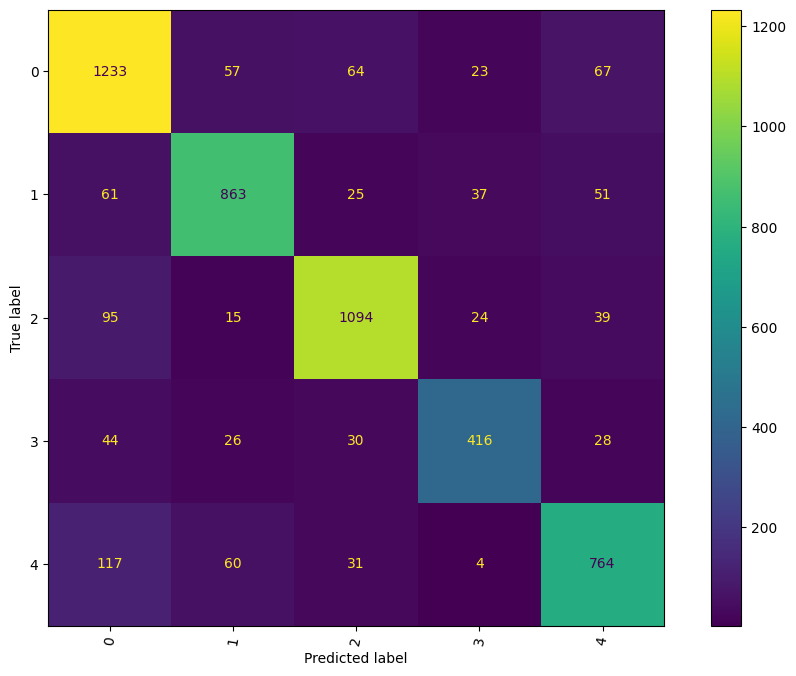

In [91]:
# Decision Tree Classification wuth GridSearchCV

dtc = DecisionTreeClassifier(random_state=40)

dtc_params = {
    'max_depth': [5,10,20,30],
    'min_samples_leaf': [5,10,20,30]
}

# create gridsearch object
grid_search_dtc = grid_search(dtc, folds, dtc_params, scoring='roc_auc_ovr')

# fit model
grid_search_dtc.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_dtc)

# Random Forest Classification Report
metric7=[]
display_classification_report(grid_search_dtc,metric7)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
OOB SCORE : 0.8345988357377879
Best Score:  0.9777105818541632
Best Hyperparameters:  {'max_depth': 40, 'min_samples_leaf': 5, 'n_estimators': 700}
ROC AUC Score Train: 0.99
ROC AUC Score Test: 0.98
Train Accuracy : 0.89
Test Accuracy : 0.83
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.83      0.97      0.90      4332
           1       0.91      0.87      0.89      3110
           2       0.90      0.94      0.92      3802
           3       0.96      0.76      0.85      1632
           4       0.94      0.81      0.87      2928

    accuracy                           0.89     15804
   macro avg       0.91      0.87      0.88     15804
weighted avg       0.90      0.89      0.89     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.77      0.94      0.85      1444
           1       0.83      0.

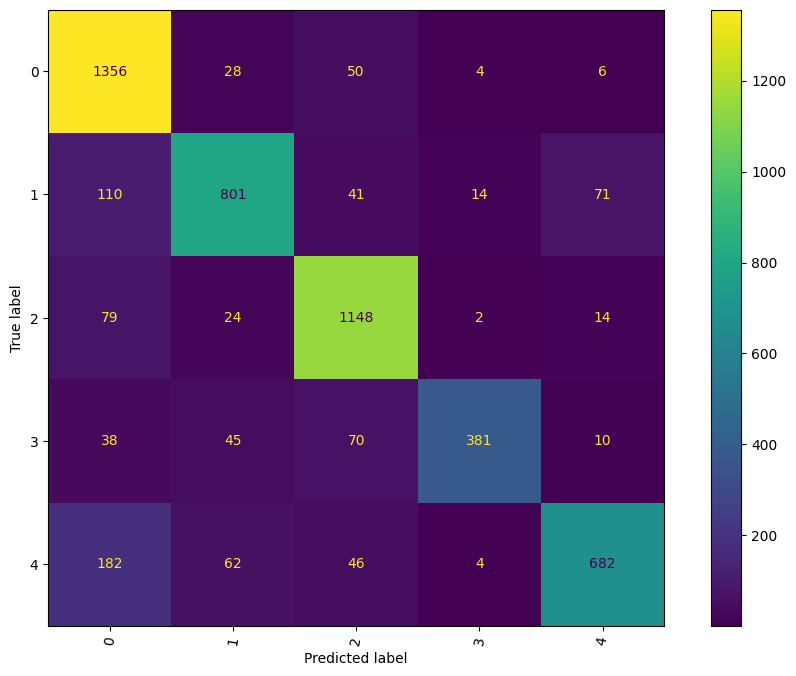

In [92]:
#Random Forest Classifier with GridSearchCV

rfc = RandomForestClassifier(random_state=40, n_jobs = -1,oob_score=True)

# hyperparameters for Random Forest
rfc_params = {'max_depth': [10,20,30,40],
          'min_samples_leaf': [5,10,15,20,30],
          'n_estimators': [100,200,500,700]
        }

# create gridsearch object
grid_search_rfc = grid_search(rfc, folds, rfc_params, scoring='roc_auc_ovr')

# fit model
grid_search_rfc.fit(X_train, y_train)

# oob score
print('OOB SCORE :',grid_search_rfc.best_estimator_.oob_score_)

# print best hyperparameters
print_best_score_params(grid_search_rfc)

# Random Forest Classification Report
metric8=[]
display_classification_report(grid_search_rfc,metric8)

## Model Inference

In [94]:
table = {'Metric': ['ROC_AUC Score(Train)','ROC_AUC Score(Test)',
                    'Accuracy(Train)','Accuracy(Test)',
                    'Precision(Train)','Precision(Test)',
                    'Recall(Train)','Recall(Test)',
                    'F1-Score(Train)','F1-Score(Test)'
                   ], 
        'Multinomial Naive Bayes': metric1
        }

mnb_metric = pd.DataFrame(table ,columns = ['Metric', 'Multinomial Naive Bayes'] )
log_metric = pd.Series(metric2, name = 'Logistic Regression')
dtc_metric = pd.Series(metric3, name = 'Decision Tree Classifier')
rfc_metric = pd.Series(metric4, name = 'Random Forest Classifier')
grid_mnb_metric = pd.Series(metric5, name = 'Multinomial Naive Bayes with GridSearchCV')
grid_log_metric = pd.Series(metric6, name = 'Logistic Regression with GridSearchCV')
grid_dtc_metric = pd.Series(metric7, name = 'Decision Tree Classifier with GridSearchCV')
grid_rfc_metric = pd.Series(metric8, name = 'Random Forest Classifier with GridSearchCV')

final_metric = pd.concat([mnb_metric,log_metric,dtc_metric,rfc_metric,
                         grid_mnb_metric,grid_log_metric,grid_dtc_metric,grid_rfc_metric], axis = 1)

final_metric


,Metric,Multinomial Naive Bayes,Logistic Regression,Decision Tree Classifier,Random Forest Classifier,Multinomial Naive Bayes with GridSearchCV,Logistic Regression with GridSearchCV,Decision Tree Classifier with GridSearchCV,Random Forest Classifier with GridSearchCV
0,ROC_AUC Score(Train),0.97,1.00,1.00,1.00,0.98,1.00,0.98,0.99
1,ROC_AUC Score(Test),0.95,1.00,0.89,0.99,0.95,1.00,0.96,0.98
2,Accuracy(Train),0.79,0.97,1.00,1.00,0.86,0.97,0.85,0.89
3,Accuracy(Test),0.74,0.95,0.83,0.88,0.78,0.96,0.83,0.83
4,Precision(Train),0.81,0.97,1.00,1.00,0.86,0.97,0.85,0.90
5,Precision(Test),0.77,0.95,0.83,0.88,0.78,0.96,0.83,0.84
6,Recall(Train),0.79,0.97,1.00,1.00,0.86,0.97,0.85,0.89
7,Recall(Test),0.74,0.95,0.83,0.88,0.78,0.96,0.83,0.83
8,F1-Score(Train),0.78,0.97,1.00,1.00,0.86,0.97,0.85,0.89
9,F1-Score(Test),0.73,0.95,0.83,0.88,0.78,0.96,0.83,0.83


# The best model looks to be Logistic Regression with GridSearchCV

## Predictions

In [95]:
# raw complaint text
test_complaint= 'I tried to make a transaction at a supermarket retail store, using my chase \
debit/atm card, but the transaction was declined. I am still able to withdraw money out of an \
ATM machine using the same debit card. Please resolve this issue.'

In [96]:
# vectorize and tf-idf tranform
test = count_vect.transform([test_complaint])
test_tfidf = tfidf_transformer.transform(test)

In [97]:
# predict
prediction=grid_search_log.predict(test_tfidf)
prediction

array([1])

In [98]:
topic_mapping[prediction[0]]

'Credit card or prepaid card'